In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import legume 
legume.set_backend('autograd')
import legume.backend as bd
import numpy as np
import autograd.numpy as npa
from autograd import grad
import time
import matplotlib.pyplot as plt
import optomization
import json

In [731]:
a = 420
phc = optomization.W1(NyChange=0,Ny=7, ra=.25 ,eps_slab=3.13,dslab=270/a)
gme = legume.GuidedModeExp(phc,2.01)
ks = npa.linspace(np.pi*.5,np.pi,100)
gmeParams = {'verbose':False,'numeig':21,'compute_im':False,'kpoints':npa.array([ks,[0]*len(ks)])}
gme.run(**gmeParams)

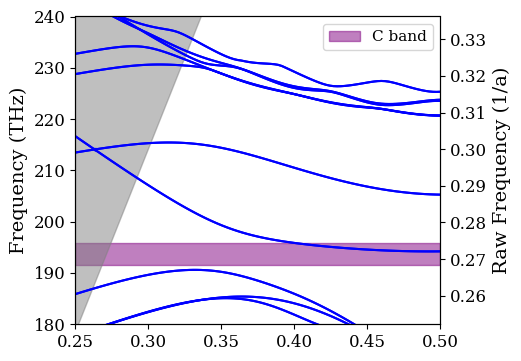

In [732]:
fconv = 299792458/a/1e-9/1e12
c_band_max = 195.9
c_band_min = 191.56

fig, ax1 = plt.subplots(figsize=(5.4, 3.8))

# Plot with frequency conversion on the left axis
ax1.plot(ks/np.pi/2, gme.freqs*fconv, color='b')
ax1.fill_between(ks/np.pi/2, c_band_min, c_band_max, color='purple', alpha=.5,label='C band')
ax1.fill_between(ks/np.pi/2, ks*fconv/np.pi/2, np.max(ks)*fconv/np.pi/2, color='gray', alpha=.5)
ax1.set_ylim(180, 240)
ax1.set_xlim(.25, 0.5)
ax1.set_ylabel('Frequency (THz)')

# Create a second y-axis without frequency conversion
ax2 = ax1.twinx()
ax2.plot(ks/np.pi/2, gme.freqs, color='b')
ax2.set_ylabel('Raw Frequency (1/a)')
# Match x-limits
ax2.set_ylim(ax1.get_ylim()[0]/fconv, ax1.get_ylim()[1]/fconv)
ax1.legend()
fig.tight_layout()
plt.show()

In [734]:
print(np.argmin(np.abs(ks/2/np.pi-gme.freqs[:,14])))

17


In [186]:
ngs = []
for i in range(len(ks)):
    ngs.append(np.abs(optomization.NG(gme,i,14,Nx=100,Ny=125)))

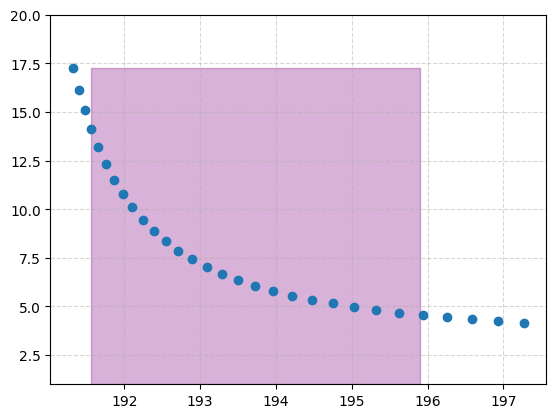

In [195]:
coff = 55
start = 25
plt.plot(gme.freqs[start:coff,14]*fconv,ngs[start:coff],'o')
plt.fill_between(np.linspace(c_band_min,c_band_max,coff), np.ones(coff), np.max(ngs[start:coff]), color='purple', alpha=0.3)
plt.grid(True,linestyle='--',alpha=0.5)
plt.ylim(1,20)
plt.show()


In [2]:
a = 455
dirs = ['media/NDBP_05/test0_ng28.json','media/ng10_tests/test0.json','media/ng20_tests/test3_20.json']
vars_list = []
kpoints = []
for dir in dirs:
    with open(dir, 'r') as f:
        data = json.load(f)
    vars_list.append(data[-2]['x_values'])
    kpoints.append(data[-1]["gmeParams"]['kpoints'][0])
vars_array = np.array(vars_list)

In [3]:
import copy
phcs = []
gmes = []
for vars in vars_array:
    phc = optomization.W1(vars=vars,Ny=7,eps_slab=3.13,dslab=270/455)
    gme = legume.GuidedModeExp(phc,3.01)
    ks = npa.linspace(np.pi*.5,np.pi,100)
    gmeParams = {'verbose':False,'numeig':21,'compute_im':False,'kpoints':npa.array([ks,[0]*len(ks)])}
    gme.run(**gmeParams)
    phcs.append(copy.deepcopy(phc))
    gmes.append(copy.deepcopy(gme))


In [4]:
ngs = []
for gme in gmes:
    ng = []
    for i in range(len(gme.freqs[:,14])):
        ng.append(np.abs(optomization.NG(gme,i,14,Nx=100,Ny=125)))
    ngs.append(ng.copy())

539.6594374557827
539.3248525594139
539.5538690203283


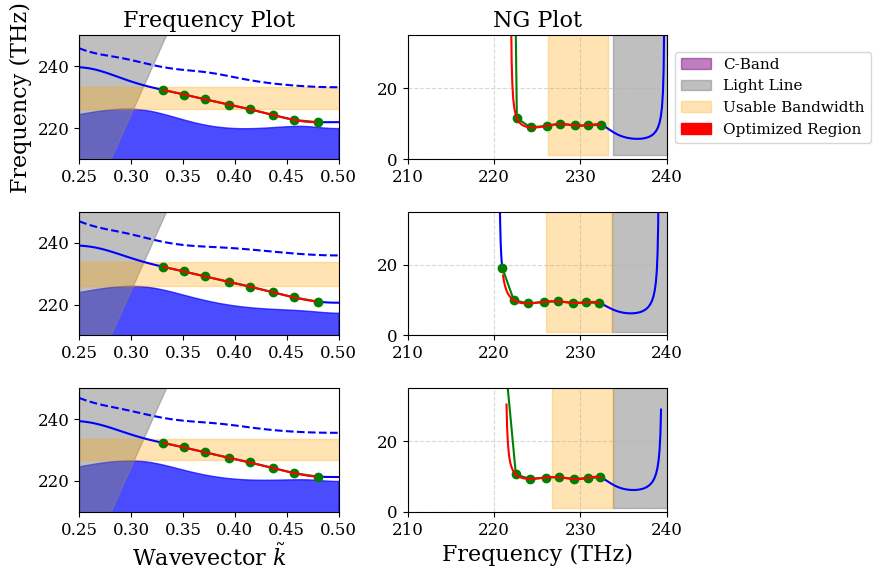

In [718]:

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
fig, ax = plt.subplots(3,2,figsize=(9,6))
ngs = np.array(ngs)

startk = 32
endk = 91
k_target = np.linspace(32,91,8).astype(int)
for i,gme in enumerate(gmes):

    #print out the conversion factor to center the c band at the start of the region
    s = gme.freqs[startk,14]*fconv/c_band_max
    print(s*455)

    #find the index that the frequency hits the light line
    light_line_index = np.argmin(np.abs(gme.freqs[:,14]-ks/np.pi/2))

    #get min and max frequency for the bandwidth
    bw_min = np.max(gme.freqs[:,14-1])*fconv
    bw_max = min(np.min(gme.freqs[:,14+1]),gme.freqs[light_line_index,14])*fconv

    #frequency plot
    # Plot the blue line outside [startk, endk]
    ax[i,0].plot(ks[:startk]/np.pi/2, gme.freqs[:startk,14]*fconv, color='b')
    ax[i,0].plot(ks[endk:]/np.pi/2, gme.freqs[endk:,14]*fconv, color='b')
    ax[i,0].plot(ks[k_target]/np.pi/2, gme.freqs[k_target,14]*fconv, color='g', marker='o')
    # Plot the red line within [startk, endk]
    ax[i,0].plot(ks[startk:endk]/np.pi/2, gme.freqs[startk:endk,14]*fconv, color='r')
    # The dashed blue line for the next band
    ax[i,0].plot(ks/np.pi/2, gme.freqs[:,15]*fconv, color='b', linestyle='--')
    ax[i,0].fill_between(ks/np.pi/2, gme.freqs[:,1]*fconv, gme.freqs[:,13]*fconv, color='b', alpha=.7)
    ax[i,0].fill_between(ks/np.pi/2, c_band_min, c_band_max, color='purple', alpha=.5, label='C band')
    ax[i,0].fill_between(ks/np.pi/2, ks*fconv/np.pi/2, np.max(ks)*fconv/np.pi/2, color='gray', alpha=.5)
    ax[i,0].fill_between(ks/np.pi/2, bw_min, bw_max, color='orange', alpha=.3)
    ax[i,0].set_xlim(0.25, 0.5)
    ax[i,0].set_ylim(210, 250)

    #ng plot
    # Plot the blue curve outside [startk, endk]
    ax[i,1].plot(gme.freqs[:startk,14]*fconv, ngs[i][:startk], color='b')
    ax[i,1].plot(gme.freqs[endk:,14]*fconv, ngs[i][endk:], color='b')
    ax[i,1].plot(gme.freqs[k_target,14]*fconv, ngs[i][k_target], color='g', marker='o')
    # Plot the red curve within [startk, endk]
    ax[i,1].plot(gme.freqs[startk:endk,14]*fconv, ngs[i][startk:endk], color='r')
    ax[i,1].fill_between(np.linspace(c_band_min, c_band_max, len(ks)), np.ones(len(ks)), np.max(ngs), color='purple', alpha=0.3)
    ax[i,1].fill_between([gme.freqs[light_line_index,14]*fconv,300],[1,1],50,color='gray',alpha=0.5)
    ax[i,1].fill_between(np.linspace(bw_min, bw_max, len(ks)), np.ones(len(ks)), np.max(ngs), color='orange', alpha=0.3)
    ax[i,1].grid(True,linestyle='--',alpha=0.5)
    ax[i,1].set_ylim(0,35)
    ax[i,1].set_xlim(210, 240)

#add labels and legends
ax[0,0].set_ylabel('Frequency (THz)',fontsize=16)
ax[2,1].set_xlabel('Frequency (THz)',fontsize=16)
ax[0,0].set_title('Frequency Plot',fontsize=16)
ax[0,1].set_title('NG Plot',fontsize=16)
ax[2,0].set_xlabel('Wavevector $\\tilde k$',fontsize=16)
# To set custom legend labels and colors, define proxy artists for the legend:
legend_handles = [
    mpatches.Patch(color='purple', alpha=0.5, label='C-Band'),
    mpatches.Patch(color='gray', alpha=0.5, label='Light Line'),
    mpatches.Patch(color='orange', alpha=0.3, label='Usable Bandwidth'),
    mpatches.Patch(color='red', alpha=1, label='Optimized Region')
]
ax[0,1].legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()
    

In [406]:
phcs_corrected = []
gmes_corrected = []
a_prime = 495
fconv_prime = 299792458/a_prime/1e-9/1e12
for vars in vars_array:
    phc = optomization.W1(vars=vars,Ny=7,eps_slab=3.13,dslab=270/a_prime)
    gme = legume.GuidedModeExp(phc,4.01)
    ks = npa.linspace(np.pi*.5,np.pi,100)
    gmeParams = {'verbose':False,'numeig':21,'compute_im':False,'kpoints':npa.array([ks,[0]*len(ks)])}
    gme.run(**gmeParams)
    phcs_corrected.append(copy.deepcopy(phc))
    gmes_corrected.append(copy.deepcopy(gme))


In [407]:
ngs_corrected = []
for gme in gmes_corrected:
    ng = []
    for i in range(len(gme.freqs[:,14])):
        ng.append(np.abs(optomization.NG(gme,i,14,Nx=100,Ny=125)))
    ngs_corrected.append(ng.copy())

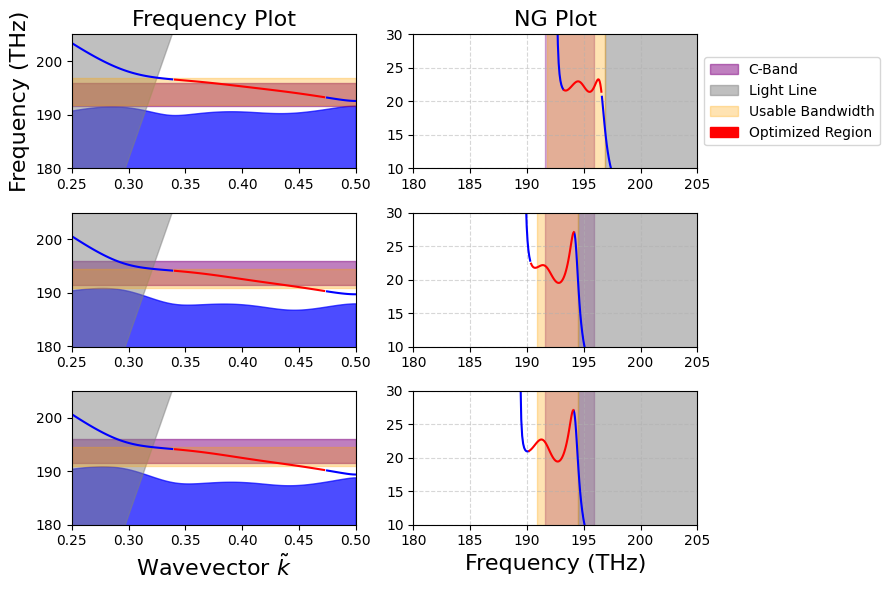

In [409]:
fig, ax = plt.subplots(3,2,figsize=(9,6))
ngs = np.array(ngs)

startk = 36
endk = 89
for i,(gme,ngs) in enumerate(zip(gmes_corrected,ngs_corrected)):

    #find the index that the frequency hits the light line
    light_line_index = np.argmin(np.abs(gme.freqs[:,14]-ks/np.pi/2))

    #get min and max frequency for the bandwidth
    bw_min = np.max(gme.freqs[:,14-1])*fconv_prime
    bw_max = min(np.min(gme.freqs[:,14+1]),gme.freqs[light_line_index,14])*fconv_prime

    #frequency plot
    # Plot the blue line outside [startk, endk]
    ax[i,0].plot(ks[:startk]/np.pi/2, gme.freqs[:startk,14]*fconv_prime, color='b')
    ax[i,0].plot(ks[endk:]/np.pi/2, gme.freqs[endk:,14]*fconv_prime, color='b')
    # Plot the red line within [startk, endk]
    ax[i,0].plot(ks[startk:endk]/np.pi/2, gme.freqs[startk:endk,14]*fconv_prime, color='r')
    # The dashed blue line for the next band
    ax[i,0].plot(ks/np.pi/2, gme.freqs[:,15]*fconv_prime, color='b', linestyle='--')
    ax[i,0].fill_between(ks/np.pi/2, gme.freqs[:,1]*fconv_prime, gme.freqs[:,13]*fconv_prime, color='b', alpha=.7)
    ax[i,0].fill_between(ks/np.pi/2, c_band_min, c_band_max, color='purple', alpha=.5, label='C band')
    ax[i,0].fill_between(ks/np.pi/2, ks*fconv_prime/np.pi/2, np.max(ks)*fconv_prime/np.pi/2, color='gray', alpha=.5)
    ax[i,0].fill_between(ks/np.pi/2, bw_min, bw_max, color='orange', alpha=.3)
    ax[i,0].set_xlim(0.25, 0.5)
    ax[i,0].set_ylim(180, 205)

    #ng plot
    # Plot the blue curve outside [startk, endk]
    ax[i,1].plot(gme.freqs[:startk,14]*fconv_prime, ngs[:startk], color='b')
    ax[i,1].plot(gme.freqs[endk:,14]*fconv_prime, ngs[endk:], color='b')
    # Plot the red curve within [startk, endk]
    ax[i,1].plot(gme.freqs[startk:endk,14]*fconv_prime, ngs[startk:endk], color='r')
    ax[i,1].fill_between(np.linspace(c_band_min, c_band_max, len(ks)), np.ones(len(ks)), np.max(ngs), color='purple', alpha=0.3)
    ax[i,1].fill_between([gme.freqs[light_line_index,14]*fconv_prime,220],[1,1],40,color='gray',alpha=0.5)
    ax[i,1].fill_between(np.linspace(bw_min, bw_max, len(ks)), np.ones(len(ks)), 40, color='orange', alpha=0.3)
    ax[i,1].grid(True,linestyle='--',alpha=0.5)
    ax[i,1].set_ylim(10,30)
    ax[i,1].set_xlim(180, 205)

#add labels and legends
ax[0,0].set_ylabel('Frequency (THz)',fontsize=16)
ax[2,1].set_xlabel('Frequency (THz)',fontsize=16)
ax[0,0].set_title('Frequency Plot',fontsize=16)
ax[0,1].set_title('NG Plot',fontsize=16)
ax[2,0].set_xlabel('Wavevector $\\tilde k$',fontsize=16)
# To set custom legend labels and colors, define proxy artists for the legend:
legend_handles = [
    mpatches.Patch(color='purple', alpha=0.5, label='C-Band'),
    mpatches.Patch(color='gray', alpha=0.5, label='Light Line'),
    mpatches.Patch(color='orange', alpha=0.3, label='Usable Bandwidth'),
    mpatches.Patch(color='red', alpha=1, label='Optimized Region')
]
ax[0,1].legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()
    

In [318]:
30*(c_band_max/fconv-c_band_min/fconv)

0.19760670563633842

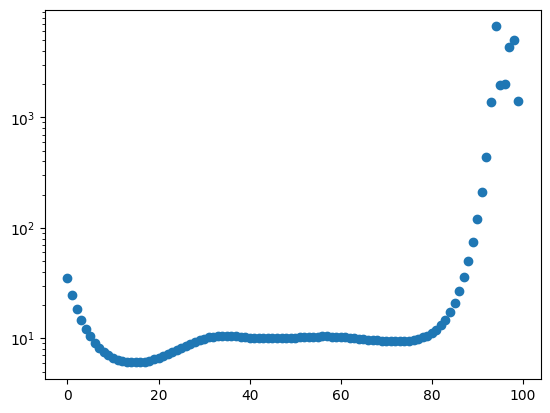

In [368]:
plt.plot(ngs_corrected[0],'o')
plt.yscale('log')

In [440]:
np.linspace(26,79,8,dtype=int)

array([26, 33, 41, 48, 56, 63, 71, 79])

In [441]:
print(k[26]-k[79])

-0.13383838383838392


In [393]:
gme.freqs[36,14]

0.3039121388189779

In [329]:
print((gme.freqs[:,14]-ks/np.pi/2)[25])

0.0021378335188044217


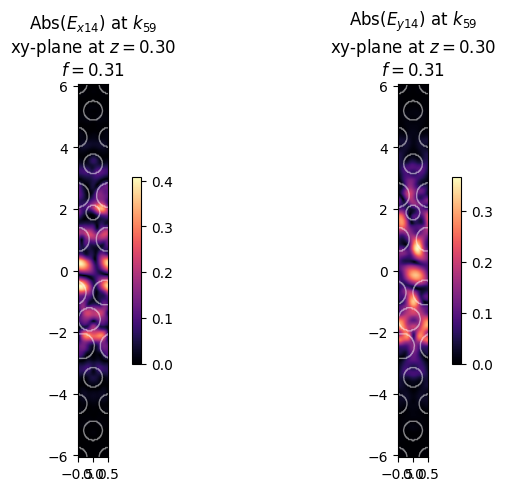

In [405]:
legume.viz.field(gme,'E',59,14,z=phc.layers[0].d/2,component='xy',val='abs',N1=100,N2=300)
plt.show()

In [445]:
c = 2.99792458e8
f_low = 1/(1550+28/2)*455
f_high = 1/(1550-28/2)*455
# f_low = c_band_min*1e12/c*455e-9#c/(1550+28/2)*450e-9
# f_high = c_band_max*1e12/c*455e-9#c/(1550-28/2)*450e-9
28*(f_high-f_low)

0.1484907821824366

In [449]:
print(np.argmin(np.abs(k-k[32]-0.1484907821824366)))

91


In [452]:
np.linspace(32,91,8,dtype=int)

array([32, 40, 48, 57, 65, 74, 82, 91])

In [453]:
print(k[32],k[91])

0.3308080808080808 0.4797979797979798


In [454]:
k[32]

0.3308080808080808

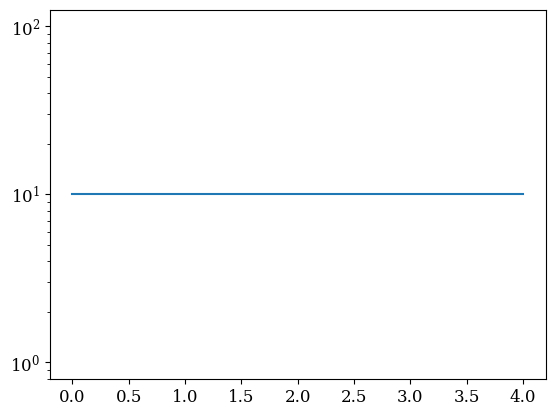

In [759]:
plt.plot(ngs[0])
plt.yscale('log')

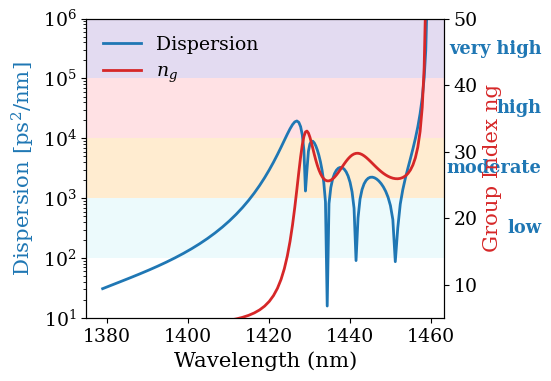

In [774]:
a=455
wls = 1/(gme.freqs[:,14]/a/1e-9)
fs_hz = gme.freqs[:,14]*299792458/a/1e-9
disp = 1/(2*np.pi*299792458)*(np.array(ngs[0][1:])-np.array(ngs[0][:-1]))/(fs_hz[1:]-fs_hz[:-1])*1e24
disp2 = wls[:-1]**2/2/np.pi/(299792458**2)*(np.array(ngs[0][1:])-np.array(ngs[0][:-1]))/(wls[1:]-wls[:-1])*1e24
text_scale = .85  # Set this to scale all text

fig, ax1 = plt.subplots(figsize=(6, 4))
color1 = 'tab:blue'
ax1.set_xlabel('Wavelength (nm)', fontsize=18*text_scale)
ax1.set_ylabel(r'Dispersion [ps$^2$/nm]', color=color1, fontsize=18*text_scale)
l1 = ax1.plot(wls[:-1]*1e9, np.abs(disp), color=color1, label=r'Dispersion', linewidth=2)
ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.tick_params(axis='both', which='major', labelsize=16*text_scale)

# Add colored regions for "low", "moderate", "high", "very high" on the Dispersion (ax1) axis at 10^x decades
region_bounds = [1e2, 1e3, 1e4, 1e5, 1e6]  # Four regions: [1e2,1e3), [1e3,1e4), [1e4,1e5), [1e5,1e6)
region_labels = ['low', 'moderate', 'high', 'very high']
region_colors = ['#e0f7fa', '#ffe0b2', '#ffcdd2', '#d1c4e9']
for i in range(4):
    ax1.axhspan(region_bounds[i], region_bounds[i+1], xmin=0, xmax=1, 
                facecolor=region_colors[i], alpha=0.6, zorder=0)
    # Place label in middle of the region
    y_mid = np.sqrt(region_bounds[i]*region_bounds[i+1])
    ax1.text(1487.5, y_mid, region_labels[i], va='center', ha='right', 
             fontsize=15*text_scale, color='tab:blue', fontweight='bold')
             # removed bbox to remove surrounding box

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Group Index ng', color=color2, fontsize=18*text_scale)
l2 = ax2.plot(wls*1e9, ngs[0], color=color2, label=r'$n_g$', linewidth=2)
ax2.set_ylim(5,50)
ax2.tick_params(axis='y', which='major', labelsize=16*text_scale)

lines = l1 + l2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=16*text_scale, frameon=False)  # frameon=False removes legend box

plt.tight_layout()
plt.show()

## Meaure the Loss through the bandwidth 

In [852]:
from optomization import Backscatter

losses = []
for j,(gme,phc) in enumerate(zip(gmes,phcs)):
    loss = []
    for i in range(len(ks)):
        cost = Backscatter(zdiv=10,a=455)
        loss.append(cost.cost(gme,phc,14,k=i))
    losses.append((10**np.array(loss))/455/1E-7*10*np.log10(np.e)*np.array(ngs[j])**2)
losses = np.array(losses)

In [798]:
kinds = [[np.argmin(np.abs(k-ks)) for k in kpoint] for kpoint in kpoints]
print(kinds)

[[32, 40, 48, 57, 65, 74, 82, 91], [29, 34, 40, 46, 52, 58], [26, 33, 41, 48, 56, 63, 71, 79]]


/var/folders/hw/03zfk07n30vg93xfdj4v1t5w0000gp/T/ipykernel_58665/1707128732.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


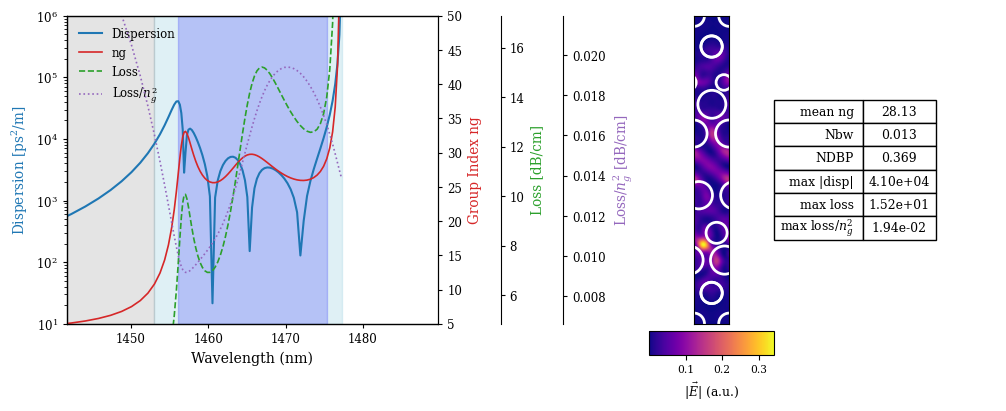

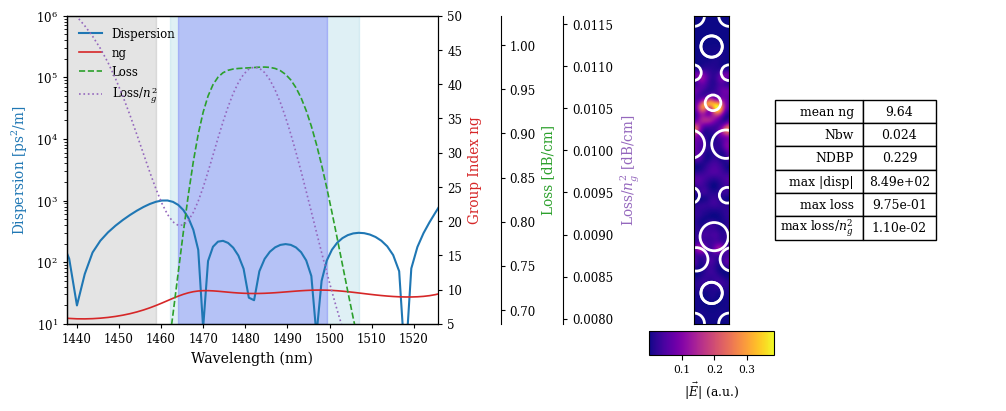

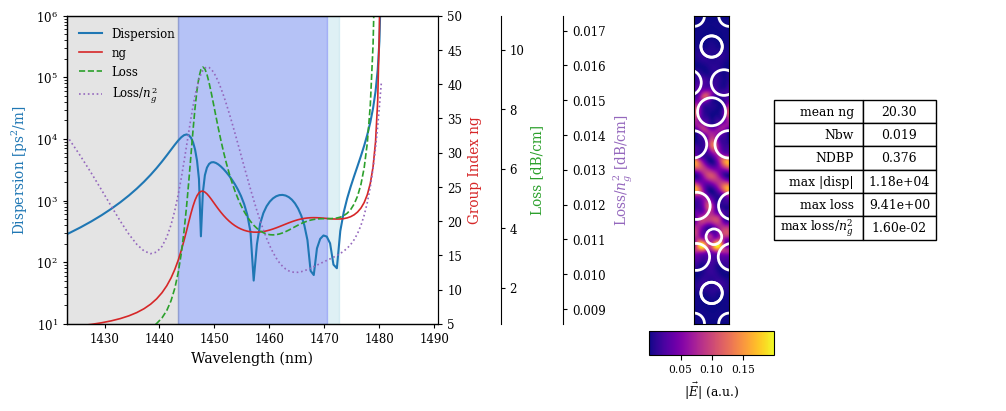

In [914]:
# One plot per loop iteration, with a compact layout and side-table of max values

from matplotlib import gridspec
from matplotlib.patches import Circle

text_scale = .85  # Set this to scale all text

max_panels = 4  # max number of plots to show
num_panels = min(len(gmes), max_panels)

for idx, (gme, ng, loss, kind) in enumerate(zip(gmes, ngs, losses, kinds)):
    if idx >= num_panels:
        break

    # ----- Cleaned up, more readable/organized plotting -----

    # Gridspec setup: [dispersion+ng+loss] | [empty] | [field imshow] | [side table]
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(
        1, 4,
        width_ratios=[2, .75, .5, 1.05],
        wspace=0.22
    )

    # ---------------------- Dispersion and Data Extraction ----------------------
    wl = 1 / (gme.freqs[:, 14] / a)  # Wavelength (nm)
    wl_band = wl[kind[0]:kind[-1]+1]
    min_wl, max_wl = wl[kind[0]], wl[kind[-1]]
    wl_range = max_wl - min_wl

    fs_hz = gme.freqs[:, 14] * 299792458 / a / 1e-9  # [Hz]

    # Dispersion
    disp = (
        1 / (2 * np.pi * 299792458)
        * (np.array(ng[1:]) - np.array(ng[:-1]))
        / (fs_hz[1:] - fs_hz[:-1])
        * 1e24
    )

    # Determine bandwidth, light line
    light_line_idx = int(np.argmin(np.abs(gme.freqs[:,14] - ks/np.pi/2)))
    light_line_wl = 1/(gme.freqs[light_line_idx, 14]/a)
    bw_min = 1/(max(np.max(gme.freqs[:,14-1]), np.min(gme.freqs[:,14]))/a)
    bw_max = 1/(min(np.min(gme.freqs[:,14+1]), gme.freqs[light_line_idx,14])/a)

    # ---------------------- Main Plot: Dispersion Curve ------------------------
    ax = fig.add_subplot(gs[0])

    # Dispersion
    ax.plot(
        wl[:-1], np.abs(disp),
        color='tab:blue', label='Dispersion', linewidth=1.5
    )
    ax.set_xlabel('Wavelength (nm)', fontsize=12 * text_scale)
    ax.set_ylabel(r'Dispersion [ps$^2$/m]', color='tab:blue', fontsize=11.5 * text_scale)
    ax.set_yscale('log')
    ax.set_ylim(1e1, 1e6)
    ax.set_xlim(min_wl - wl_range * 0.75, max_wl + wl_range * 0.75)
    ax.tick_params(axis='both', which='major', labelsize=10 * text_scale, length=3)

    # Highlight regions
    ax.fill_between([bw_min, bw_max], 1e1, 1e6, color='lightblue', alpha=0.38)
    ax.fill_between([min_wl, max_wl], 1e1, 1e6, color='blue', alpha=0.19)
    ax.fill_between([min_wl - wl_range * 0.75, light_line_wl], 1e1, 1e6, color='gray', alpha=0.21)

    # ------------------------- Other Y Axes -------------------------
    # Group Index (ng)
    ax2 = ax.twinx()
    ax2.plot(
        wl, ng,
        color='tab:red', label='ng', linewidth=1.2
    )
    ax2.set_ylabel('Group Index ng', color='tab:red', fontsize=11.5 * text_scale)
    ax2.tick_params(axis='y', which='major', labelsize=10 * text_scale, length=3)
    ax2.set_ylim(5, 50)

    # Loss (dB/cm)
    ax3 = ax.twinx()
    ax3.spines.right.set_position(("outward", 45))
    loss_visible = loss[kind[0]:kind[-1]+1]
    loss_range = np.ptp(loss_visible)
    ax3.plot(
        wl, loss,
        color='tab:green', label='Loss', linewidth=1.2, linestyle='--'
    )
    ax3.set_ylabel(r'Loss [dB/cm]', color='tab:green', fontsize=11.5 * text_scale)
    ax3.tick_params(axis='y', which='major', labelsize=10 * text_scale, length=3)
    ax3.set_ylim(
        np.min(loss_visible) - 0.25 * loss_range,
        np.max(loss_visible) + 0.25 * loss_range
    )

    # Loss / ng^2
    ax4 = ax.twinx()
    ax4.spines.right.set_position(("outward", 90))
    loss_ng2 = loss / (np.array(ng) ** 2)
    loss_ng2_visible = loss_ng2[kind[0]:kind[-1]+1]
    loss_ng2_range = np.ptp(loss_ng2_visible)
    ax4.plot(
        wl, loss_ng2,
        color='tab:purple', label=r'Loss/$n_g^2$', linewidth=1.2, linestyle=':'
    )
    ax4.set_ylabel(r'Loss/$n_g^2$ [dB/cm]', color='tab:purple', fontsize=11.5 * text_scale)
    ax4.tick_params(axis='y', which='major', labelsize=10 * text_scale, length=3)
    ax4.set_ylim(
        np.min(loss_ng2_visible) - 0.25 * loss_ng2_range,
        np.max(loss_ng2_visible) + 0.25 * loss_ng2_range
    )

    # ----- Compose legend with custom order -----
    lines = (
        [ax.lines[0]] +
        [ax2.lines[0]] +
        [ax3.lines[0]] +
        [ax4.lines[0]]
    )
    labels = ["Dispersion", "ng", "Loss", "Loss/$n_g^2$"]
    ax.legend(
        lines, labels,
        loc='upper left',
        fontsize=10 * text_scale,
        frameon=False,
        borderaxespad=0.6
    )

    # ------------------ Table Values (Summary Metrics) ------------------
    ng_mean = np.mean(ng[kind[0]:kind[-1]+1])
    Nbw = (max_wl - min_wl) / (min_wl + wl_range/2)
    NDBP = ng_mean * Nbw
    disp_max = np.max(np.abs(disp[kind[0]:kind[-1]]))
    loss_max = np.max(loss_visible)
    max_loss_ng2 = np.max(loss_ng2_visible)
    # Each row is a single value (as a single column)
    cell_text = [
        [f"{ng_mean:.2f}"],
        [f"{Nbw:.3f}"],
        [f"{NDBP:.3f}"],
        [f"{disp_max:.2e}"],
        [f"{loss_max:.2e}"],
        [f"{max_loss_ng2:.2e}"]
    ]
    row_labels = [
        "mean ng",
        "Nbw",
        "NDBP",
        "max |disp|",
        "max loss",
        "max loss/$n_g^2$"
    ]

    # ------------------ Field Imshow ------------------
    field_ax = fig.add_subplot(gs[2])
    ylim = 10 * np.sqrt(3) / 2
    ys = np.linspace(-ylim / 2, ylim / 2, 300)
    mode = 14
    kindex = kind[len(kind)//2]
    z = gme.phc.layers[0].d / 2

    # Get field of original crystal
    fields, _, _ = gme.get_field_xy('E', kindex, mode, z, ygrid=ys, component='xyz')
    eabs = np.abs(np.conj(fields['x'])*fields['x'] +
                  np.conj(fields['y'])*fields['y'] +
                  np.conj(fields['z'])*fields['z'])

    # Imshow of field
    cax1 = field_ax.imshow(
        eabs,
        extent=[-.5, .5, -ylim/2, ylim/2],
        cmap='plasma'
    )
    # Add circles for inclusions
    for s in gme.phc.layers[0].shapes:
        circle = Circle((s.x_cent, s.y_cent), s.r, edgecolor='white', facecolor='none', linewidth=2)
        surround = Circle((0, 0), s.r, edgecolor='white', facecolor='none', linewidth=2)
        field_ax.add_patch(circle)
        surround.center = (circle.center[0] - np.sign(circle.center[0]), circle.center[1])
        field_ax.add_patch(surround)
    field_ax.set_ylim(-ylim/2, ylim/2)
    field_ax.set_xlim(-0.5, 0.5)
    field_ax.tick_params(
        axis='both', which='both',
        bottom=False, top=False, left=False, right=False,
        labelbottom=False, labelleft=False
    )

    # Colorbar below field plot
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbar_ax = inset_axes(
        field_ax,
        width="70%", height="10%",
        loc='lower center',
        bbox_to_anchor=(-2, -0.1, 5, .75),
        bbox_transform=field_ax.transAxes, borderpad=0
    )
    cb = plt.colorbar(cax1, cax=cbar_ax, orientation='horizontal')
    cb.set_label(r'$|\vec{E}|$ (a.u.)', fontsize=10.5 * text_scale)
    cb.ax.tick_params(labelsize=9 * text_scale)

    # ------------------ Rightmost Table Panel ------------------
    table_ax = fig.add_subplot(gs[3])
    table_ax.axis('off')
    table = table_ax.table(
        cellText=cell_text,
        rowLabels=row_labels,
        loc='center',
        cellLoc='center',
        rowLoc='right'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10.5 * text_scale)
    table.scale(0.95, 1.4)
    table.auto_set_column_width([0, 1])

    plt.tight_layout()
    plt.show()

In [3]:
for i,var in enumerate(vars_array):
    optomization.dispLossPlot(var,optomization.W1,kpoints[i],'media/save_test/dispLossPlot_'+str(i)+'.png',gmax=3.01,phcParams={"Ny":7,"dslab":270/455,"eps_slab":3.13},mode=14,a=455,final_cost=10)

/Users/dominic/Desktop/optGME/optomization/utils.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
